In [9]:
# ============== DOWNLOAD THE IMAGES ============
import os
import requests

classes = ['cat', 'dog', 'tree', 'clock']
base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap"
save_dir = "/content/quickdraw_npy"
os.makedirs(save_dir, exist_ok=True)

for cls in classes:
    url = f"{base_url}/{cls}.npy"
    save_path = f"{save_dir}/{cls}.npy"

    if not os.path.exists(save_path):
        print(f"⬇️ Downloading {cls}.npy...")
        r = requests.get(url)
        with open(save_path, 'wb') as f:
            f.write(r.content)
    else:
        print(f"✔️ {cls}.npy already exists.")
print("✅ All downloads done.")


⬇️ Downloading cat.npy...
⬇️ Downloading dog.npy...
⬇️ Downloading tree.npy...
⬇️ Downloading clock.npy...
✅ All downloads done.


In [15]:
import os

print("Files in /content/quickdraw_npy:")
print(os.listdir("/content/quickdraw_npy"))


Files in /content/quickdraw_npy:
['dog.npy', 'tree.npy', 'cat.npy', 'clock.npy']


In [17]:
# MAKES COMBINED DATASET WITH 1000 IMAGES EACH FROM ALL 4 CXATEGORIES AND SPLIT THEM INTO TRAIN TEST DATASETS


import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Classes you want to include
classes = ['cat', 'dog', 'tree', 'clock']
class_labels = {cls: i for i, cls in enumerate(classes)}

X = []
y = []

# Load 1000 samples per class and label
for cls in classes:
    data = np.load(f"/content/quickdraw_npy/{cls}.npy")
    X.append(data[:1000])  # take only first 1000 images
    y.append(np.full(1000, class_labels[cls]))  # e.g., 0 for cat, 1 for dog

# Stack everything together
X = np.concatenate(X, axis=0).reshape(-1, 28, 28, 1) / 255.0  # normalize and reshape
y = np.concatenate(y, axis=0)

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

'''Perfect, Tekendra! That means you've successfully:

🧠 Created a mixed dataset from 4 classes (cat, dog, tree, clock)

🎯 Preprocessed it correctly (normalized + reshaped)

🎲 Shuffled and split into train/test sets'''



X_train shape: (3200, 28, 28, 1)
y_train shape: (3200,)


"Perfect, Tekendra! That means you've successfully:\n\n🧠 Created a mixed dataset from 4 classes (cat, dog, tree, clock)\n\n🎯 Preprocessed it correctly (normalized + reshaped)\n\n🎲 Shuffled and split into train/test sets"

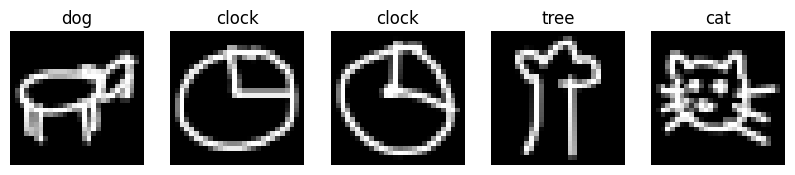

In [18]:
# VIEW SOME RANDOM IMAGES FROM THE DATASET


import matplotlib.pyplot as plt
import numpy as np

# Suppose you have your dataset X (N, 28, 28, 1) and labels y (N,)
# Let's visualize 5 random images:

def show_random_images(X, y, class_names, num=5):
    indices = np.random.choice(len(X), num, replace=False)
    plt.figure(figsize=(10, 2))

    for i, idx in enumerate(indices):
        img = X[idx].reshape(28, 28)  # remove channel dimension
        label = class_names[y[idx]]

        plt.subplot(1, num, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

# Your class names map, for example
class_names = ['cat', 'dog', 'tree', 'clock']

# Call the function with your training data
show_random_images(X_train, y_train, class_names)


# ABA ARU KAM VAYO NOW STARTS THE REAL NEURAL NETWORK MAKING
# YO STEPS HARU GARNE:
'''
1. image line (28*28)
2. use n filters of (3*3)  no of wts = 3*3* no of filters + bias= no of filters
3. we get feature map  (26*26) ko
4. pass feature map into relu (negative value 0 hunxa positive same hunxa)  (26*26)
5. max pooling use garne (2*2)ko and stride=2     (feature map sano hunxa i.e. half) .......output of (13* 13)
6. flattern i.e convert 2D images to 1D tensor   (13, 13) ko 1D tensor for single image
7. Pass that flaterned tensor into the neural networks.
8. output layer with perceptron in this layer= no of category
USE SOFTMAX FOR CLASSIFICATION i.e pass the output from the output layer into the softmax.

In [19]:
import numpy as np

# ===== ReLU =====

# ReLU = Rectified Linear Unit. It replaces all negative values with 0, and keeps positive values unchanged. 📈 Used to add non-linearity to the model.
def relu(x):
    return np.maximum(0, x)



# ===================== MAX POOLING 2x2 with stride 2 ===================================

#Takes a 2x2 region and picks the maximum value (downsampling).
#🔸 Reduces size of image by half → e.g. from (26x26) → (13x13)

def max_pooling(feature_map):          # feature map is the 2D array output got from filter(i.e. RELU bata)
    h, w = feature_map.shape           # shape of the feature map i.e. h=HEIGHT   w= WIDTH
    out = np.zeros((h // 2, w // 2))   #Create an empty array to store the pooled result i.e. yaha half of the inputs: (26, 26)=> (13, 13)


    for i in range(0, h, 2):                 # Loop through the feature map with steps of 2 (stride = 2)
        for j in range(0, w, 2)              # i moves down (rows), j moves right (columns)   So each iteration covers one 2×2 block like this:
            out[i//2, j//2] = np.max(feature_map[i:i+2, j:j+2])          # This line grabs a 2×2 region starting at (i, j)
                                                                          # Then applies np.max() to that 2×2 block → selects maximum value and Places that max value in the output array at position (i//2, j//2)
    return out

# Why i//2, j//2?   ==== Because we are reducing size by half, so every (i,j) in input becomes (i//2, j//2) in output.





# ================== SOFTMAX ===========================

#Converts raw scores into probabilities that add up to 1
#🎯 Used in the output layer to represent confidence for each class (e.g. 20% cat, 80% dog)
#  The softmax function takes a vector of raw scores (called logits) from the output layer and turns them into probabilities that: Are between 0 and 1  and Sum of probabilities of all category is 1

def softmax(x):                  # x is a 1D NumPy array — the output scores from the final layer of the network (before activation)
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)





# ===== Convolution Layer (Single filter)  output= feature map =====

# Applies a filter (kernel) to the image using a sliding window.
# At each position, it multiplies region values and filter weights, adds bias, and stores the result.
# 🧠 This is how CNN "sees" edges, curves, shapes, etc.

def convolve(image, filt, bias):
    h, w = image.shape
    fh, fw = filt.shape    # filter ko height ra width
    out_h = h - fh + 1
    out_w = w - fw + 1
                       ''' (28, 28) => (26, 26)
                       ''' # ailesamma output ko height ra width kati hunxa nikalyo and stored in out_h and out_w
                           # We’re using valid convolution (no padding), so the output size shrinks.

    out = np.zeros((out_h, out_w))         # Prepares an empty 2D array for the feature map.

    # Initially filled with zeros — we will fill it with convolution results from the following lope
    for i in range(out_h):
        for j in range(out_w):
            region = image[i:i+fh, j:j+fw]
                        '''Extracts a 3×3 block from the image at position (i, j)
                        For example, if i=5, j=7, this will take the block:
                        image[5:8, 7:10]'''

            out[i, j] = np.sum(region * filt) + bias
                        ''' Performs element-wise multiplication between region and filter
                        Then sums all the products
                        Adds the bias
                        Stores the result in the output feature map at position (i, j)'''
    return out
    #  After the loop finishes, out holds the entire convolved image (feature map).






# ===== Fully Connected Layer =====

# Takes a flattened vector (from image) and connects to output neurons.
#  This layer gives raw scores for each class.

def fully_connected(flat_input, weights, bias):
    return np.dot(flat_input, weights) + bias
              ''' 🔚 Output:
              Returns a vector of raw scores (logits) — one for each class.
              You pass this into softmax to convert them into probabilities '''


28x28 image


   ↓

Convolution (3x3)

   ↓

ReLU

   ↓

Max Pooling (2x2, stride 2)

   ↓

Flatten (13x13xN)

   ↓

Fully connected layer (output: 4 values)

   ↓
   
Softmax → [p_cat, p_dog, p_tree, p_clock]


# YO forwad_pass() FUNCTION LE CONVOLUTION LAYER MA HUNE SABAI KAM LAI HANDLE GARXA i.e.   
1. CONVOLVE GARXA
2. RELU MA PATHAUXA   
3. MAX POOLING   
4. CREATES ARRAY OF ALL THE FEATURE MAPS FOR THAT IMAGE    
5. FLATTERNS AND MAKES READY TO PASS INTO FULLY CONNECTED LAYERS.

In [21]:

def forward_pass(image, conv_filters, conv_biases):
    feature_maps = []       # Initialize an empty list to store the output of each filter (i.e., each feature map).   After applying filters, each filter produces a 2D map → we collect all of them here.


                        ''' Loop through all filters and their corresponding biases.
                        conv_filters: list of 2D filters (e.g., 3×3)
                        conv_biases: list of scalar bias values (1 per filter)
                        zip() pairs them'''
    for f, b in zip(conv_filters, conv_biases):

        fm = convolve(image, f, b)    # Apply your convolve() function to the image using the current filter f and bias b. Output is a 2D feature map (e.g., 26×26

        fm = relu(fm)    # Pass the feature map through the ReLU function.

        fm = max_pooling(fm)      # Applies 2×2 max pooling with stride 2  and Reduces spatial dimensions (from 26×26 to 13×13)

        feature_maps.append(fm)    # Add the current feature map to the list of feature maps.  we will have multiple 13×13 maps each from different filters

    conv_output = np.array(feature_maps) # Convert the list of feature maps into a single NumPy array  Final shape: (num_filters, height, width) → e.g. (8, 13, 13)
                                        # This is the 3D output volume from the convolutional layers

    flat = conv_output.reshape(-1)         # Flattens the 3D output into a 1D vector
    return flat
                    ''' Returns the flattened vector — this is the final output of the convolutional stack (before classification).
                    Next, this gets passed into fully_connected() → softmax() → prediction.'''





# ======== LOSS FUNCTION =================================

# This function calculates the cross-entropy loss for a single prediction. It measures how far off your model’s predicted probability (preds) is from the correct label.
# preds: A 1D array of predicted probabilities (after softmax), e.g. [0.1, 0.3, 0.2, 0.4]
# label:  The true class index (e.g. 2 if it’s class #2)

def cross_entropy(preds, label):
    epsilon = 1e-10
    return -np.log(preds[label] + epsilon)      # Loss= −log(predicted probability of the correct class)




# ========= CALCULATE DERIVATIVE dL/dz =========================

# This function calculates the gradient of the loss (cross-entropy) with respect to the logits (z) that were passed into the softmax.

def softmax_grad(preds, label):
    grad = preds.copy()
    grad[label] -= 1  # dL/dz = p - y (one-hot)
    return grad


preds = softmax(z) (probabilities for each class)

y is the true label (not one-hot, just an index)

Then:

∂
Loss/∂
𝑧
𝑖
=
softmax
(
𝑧
)
𝑖
−
𝑦
𝑖

In [22]:
# ==== Data ====
classes = ['cat', 'dog', 'tree', 'clock']
n_classes = len(classes)
n_filters = 8               # Each image will be processed through 8 different 3×3 filters.
filter_size = 3
flattened_size = 13 * 13 * n_filters     # flattened_size = 1352 → After convolution and pooling, each image becomes (8, 13, 13) → flatten to 1352-length vector for FC layer.

# ============ Random INITILIZATION ============
np.random.seed(0)
conv_filters = [np.random.randn(3, 3) * 0.1 for _ in range(n_filters)]
conv_biases = [0.0 for _ in range(n_filters)]
fc_weights = np.random.randn(flattened_size, n_classes) * 0.1  # no of weights = flatterened size(i.e. 13*13 * 8 (no of filters)) * 4 (i.e. no of output classes)
fc_biases = np.zeros(n_classes)     # no of fully connected layers = no of classes and initialize all the biases to 0.

# ==== Training ====
lr = 0.01   #Learning Rate
EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0     # initialize total loss
    correct = 0     # initialize the no of correctly classified images
    X_train, y_train = shuffle(X_train, y_train)  # suffles the images for better working

    for i in range(len(X_train)):     # let(X_train)= no of images in the X_train. ===> This is to lope through all the training images
        img = X_train[i].reshape(28, 28)
        label = y_train[i]            # the label i.e. actual type of that specific images i.e. expected/correct output

        # Forward pass
        flat = forward_pass(img, conv_filters, conv_biases)     # pass thhe image, the weights of all the filters and their biases into forward_pass() function which gives a flattened 1D array ready to pass into fully connected layer.

        logits = fully_connected(flat, fc_weights, fc_biases)   # pass the output 1D array from forward_pass() to fully_connected() along with the weights and biases

        probs = softmax(logits)    # pass the output from fully connected to softmax() to get the probabilities

        # Loss
        loss = cross_entropy(probs, label)  # calculates loss function based on the probabilities and the label
        total_loss += loss
        pred = np.argmax(probs)

        if pred == label:
            correct += 1   # if predicted output is same as label then increment the no of correctly predicted images




        # =========BACKPROPAGATION  (only FC layer)==============================
        grad_softmax = softmax_grad(probs, label)
        grad_w = np.outer(flat, grad_softmax)
        grad_b = grad_softmax

        # ================= Gradient Descent update ================
        fc_weights -= lr * grad_w
        fc_biases -= lr * grad_b

    acc = correct / len(X_train)
    print(f"📚 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | Accuracy: {acc*100:.2f}%")


📚 Epoch 1/5 | Loss: 1859.0719 | Accuracy: 77.72%
📚 Epoch 2/5 | Loss: 1435.7172 | Accuracy: 82.41%
📚 Epoch 3/5 | Loss: 1353.0172 | Accuracy: 83.59%
📚 Epoch 4/5 | Loss: 1296.1134 | Accuracy: 84.47%
📚 Epoch 5/5 | Loss: 1258.5482 | Accuracy: 84.91%
